# __Predicting Arabic Handwritten Digits with Simple Convolutional Layers__
#### _Any advice is appreciated!_

## Import libraries:

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Data loading:

In [ ]:
# Get the data and labels
train_data = pd.read_csv("csvTrainImages 60k x 784.csv")
test_data = pd.read_csv("csvTestImages 10k x 784.csv")
train_label = pd.read_csv("csvTrainLabel 60k x 1.csv")
test_label = pd.read_csv("csvTestLabel 10k x 1.csv")

## Data Exploration:

In [ ]:
# Let's take a look at the shape of the data
train_data.shape

(59999, 784)

In [ ]:
train_label.iloc[:,0]

0        1
1        2
2        3
3        4
4        5
        ..
59994    5
59995    6
59996    7
59997    8
59998    9
Name: 0, Length: 59999, dtype: int64

<Axes: xlabel='0'>

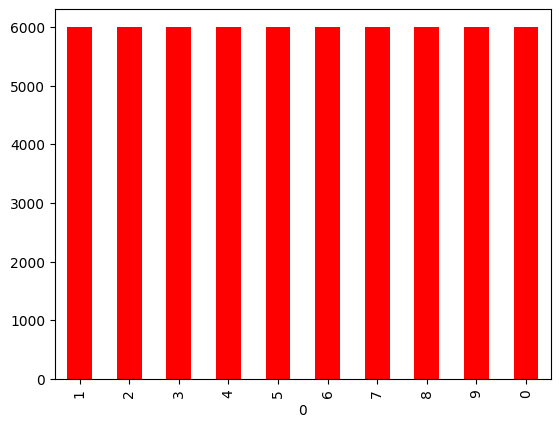

In [ ]:
# Let's look at the label's distribution
train_label.iloc[:, 0].value_counts().plot(cmap = "autumn", kind = "bar")

* We could see that the labels are distributed equally. This means that we could use accuracy for our evaluation metrics.
* We could also use Precision, Recall, F1-scores.

In [ ]:
# Let's one hot encode the labels:
y_train = np.zeros(shape=(train_label.shape[0], train_label.values.max() + 1))
for index, row in train_label.iterrows():
    y_train[index][row["0"]] = 1

In [ ]:
y_test = np.zeros(shape=(test_label.shape[0], test_label.values.max() + 1))
for index, row in test_label.iterrows():
    y_test[index][row["0"]] = 1

In [ ]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Since the shape of the data is of the format `[batchsize, height*width*channel]`, let's convert it to the format`[batchsize, height, width]`, channel is 1 (grayscale)

In [ ]:
# Let's first convert the data to numpy array for better array manipulation:
x_train = train_data.to_numpy()
x_test = test_data.to_numpy()

In [ ]:
# Let's reshape it:
x_train = x_train.reshape(x_train.shape[0], 28, 28)
x_test = x_test.reshape(x_test.shape[0], 28, 28)

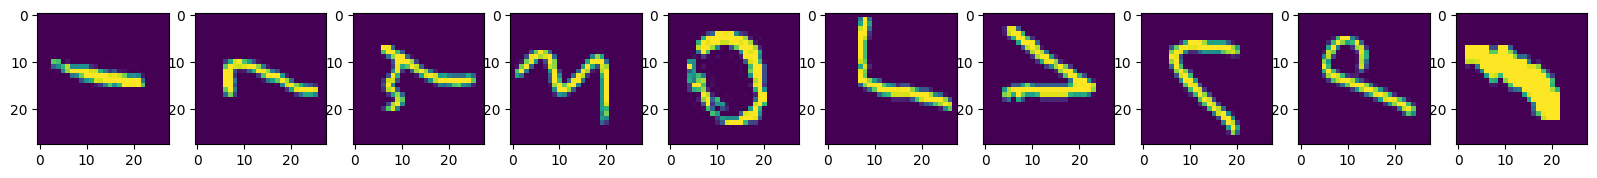

In [ ]:
fig, ax = plt.subplots(1,10, figsize = (20,20))
for i in range(10):
    ax[i].imshow(x_train[i])

#### It looks like the numbers are flipped and inverted. Let's do a transpose to the numpy array to see if it gets any better

In [ ]:
# Let's transpose all the data:
x_train = np.array([element.transpose() for element in x_train])
x_test = np.array([element.transpose() for element in x_test])

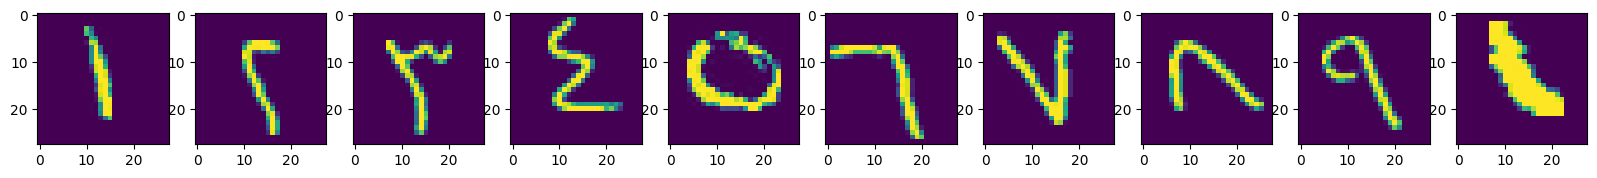

In [ ]:
fig, ax = plt.subplots(1,10, figsize = (20,20))
for i in range(10):
    ax[i].imshow(x_train[i])

* This looks much better!
* It looks like the numbers are in order, let's see if they are not randomly mixed

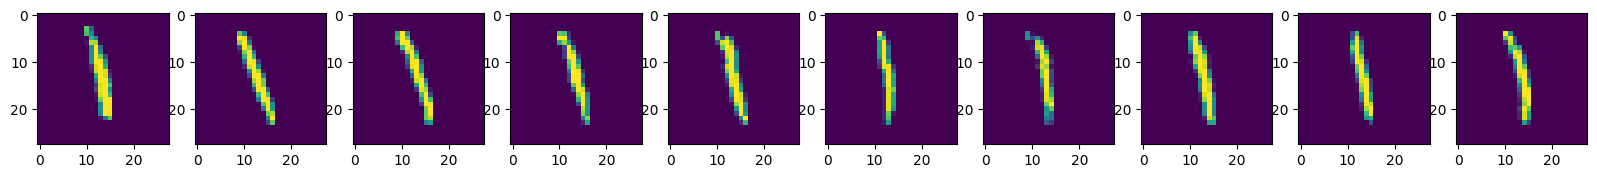

In [ ]:
fig, ax = plt.subplots(1,10, figsize = (20,20))
for i in range(10):
    ax[i].imshow(x_train[i*10])

* The numbers are in order. This means that we need to randomly arrange them before we start fitting them into model

In [ ]:
# Let's get a list of shuffled indexes so that we could apply the order to bothe the data and the label
train_shuffle_idx = np.arange(x_train.shape[0])
test_shuffle_idx = np.arange(x_test.shape[0])
np.random.shuffle(train_shuffle_idx)
np.random.shuffle(test_shuffle_idx)

In [ ]:
# Shuffle:
x_train = x_train[train_shuffle_idx]
y_train = y_train[train_shuffle_idx]
x_test = x_test[test_shuffle_idx]
y_test = y_test[test_shuffle_idx]

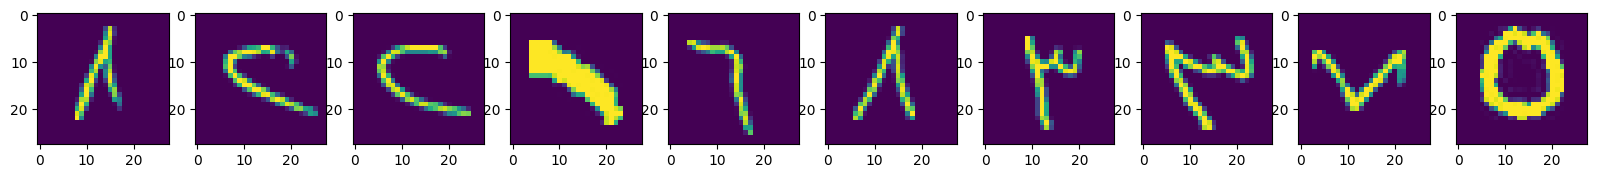

In [ ]:
fig, ax = plt.subplots(1,10, figsize = (20,20))
for i in range(10):
    ax[i].imshow(x_train[i*10])

In [ ]:
# Let's see if the labels are true:
for i in range(10):
    print(y_train[i*10].argmax())

8
2
2
0
6
8
3
3
7
5


* Now, the data is shuffled and all is good

In [ ]:
# Print the minimum and maximum values
print(x_train_min)
#print(x_train_max)

0.0


In [ ]:
x_train.max()

255

In [ ]:
#Let's apply normalization to the data:
x_train = tf.keras.utils.normalize(x_train)
x_test = tf.keras.utils.normalize(x_test)

In [ ]:
print(f"x_train's min value: {x_train.min()}\nx_train's max value: {x_train.max()}")

x_train's min value: 0.0
x_train's max value: 1.0


#### __Our model will take the input of shape `[batchsize, height, width, channel]`, so we need to reshape our numpy arrays to be of the same shape:__

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [ ]:
x_train.shape

(59999, 28, 28, 1)

## __Making the model:__

Our model will consist of:
* * Convolutional 2D layer with 32 or 64 filters (giving us "n" feature maps), kernel size of 3(shape = (3X3)), stride = 1, padding = "same" so that we get the same shape as input
* * Maxpooling layer with the shape (2,2), stride = 2
* * Batch normalization layer so that we don't have to worry about the parameter initializations and we would suffer less from internal covariate shift (Batch normalization also discards the need for regularization methods such as dropout layers). Briefly speaking, batch normalization centers and scales each mini-batch to be centered (around mean = 0 and stddev around 1) and performs linear transformation such that output = slope * ((x - mean(x_minibatch))/stddev(x_minibatch)) + beta. The reason why we perform linear transformation is so that the output can leverage and exploit the activation functions.
* We would repeat the above set of layers 3 times, then add:
* * A flatten layer that flattens the outputs
* * A dense layer with 10 nodes and activation function "softmax" so that we could predict the outputs and optimize them

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5,activation="relu", padding="same", input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid"))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid"))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3,activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1,1), padding="valid"))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 14, 14, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                      

In [ ]:
# We will use the Adam optimizer which is similar to SGD
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# We will let the learning rate decrease by a factor of 0.2 once the accuracy does not improve for 3 epochs.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.0, verbose=1)
# We will stop learning our val_accuracy does not mprove after 7 epochs
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=7, verbose=1)

In [ ]:
# Compile the model:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

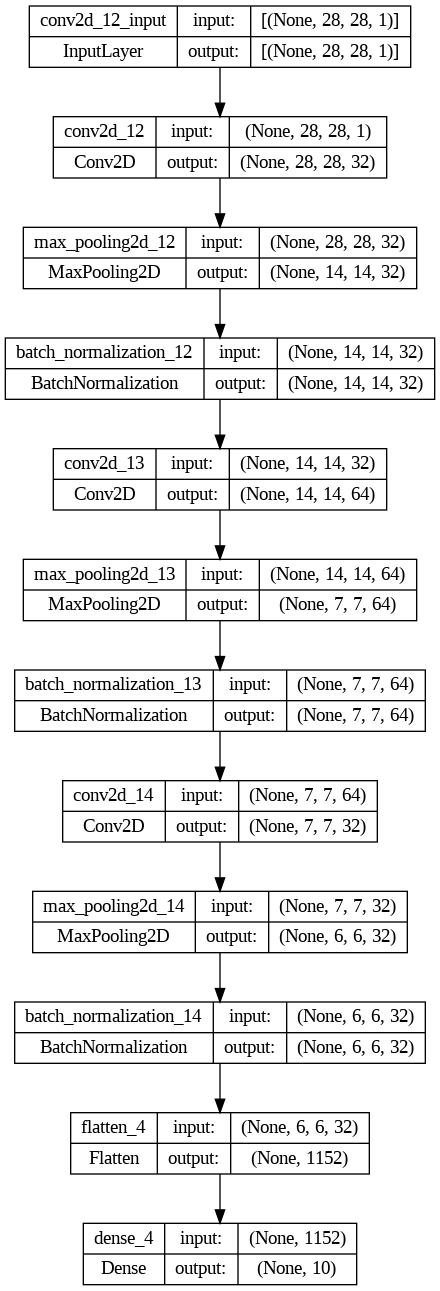

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
# Training the model:
hist = model.fit(x=x_train, y=y_train, batch_size=32, epochs=40, validation_split=0.2, callbacks=[reduce_lr, earlyStop])

Epoch 1/40
1500/1500 [==============================] - 92s 60ms/step - loss: 0.0581 - accuracy: 0.9829 - val_loss: 0.0355 - val_accuracy: 0.9885 - lr: 0.0010
Epoch 2/40
1500/1500 [==============================] - 90s 60ms/step - loss: 0.0279 - accuracy: 0.9915 - val_loss: 0.0248 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 3/40
1500/1500 [==============================] - 90s 60ms/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.0214 - val_accuracy: 0.9935 - lr: 0.0010
Epoch 4/40
1500/1500 [==============================] - 99s 66ms/step - loss: 0.0169 - accuracy: 0.9946 - val_loss: 0.0210 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 5/40
1500/1500 [==============================] - 90s 60ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.0196 - val_accuracy: 0.9946 - lr: 0.0010
Epoch 6/40
1500/1500 [==============================] - 88s 59ms/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.0245 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 7/40
1500/1500 [========================

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 8s 25ms/step - loss: 0.0381 - accuracy: 0.9925


[0.03806060925126076, 0.9924992322921753]

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

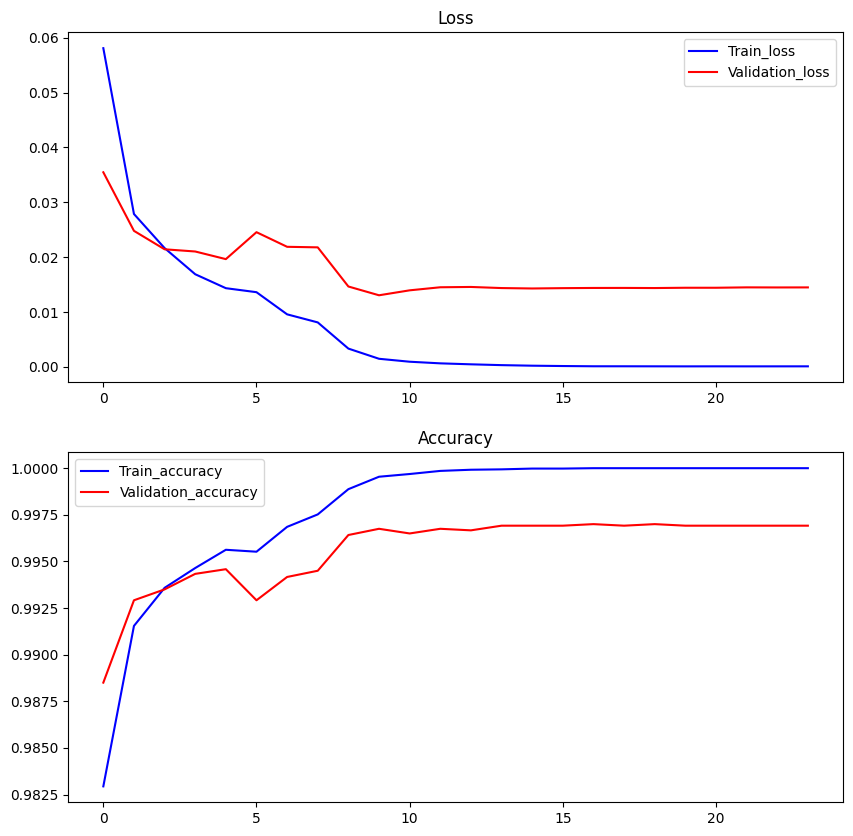

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

ax[0].set_title("Loss")
ax[0].plot(hist.history["loss"], c="b", label="Train_loss")
ax[0].plot(hist.history["val_loss"], c="r", label="Validation_loss")
ax[0].legend(loc="best")

ax[1].set_title("Accuracy")
ax[1].plot(hist.history["accuracy"], c="b", label="Train_accuracy")
ax[1].plot(hist.history["val_accuracy"], c="r", label="Validation_accuracy")
ax[1].legend(loc="best");

In [ ]:
sample = x_test[:10]

In [ ]:
pred = model.predict(sample)

1/1 [==============================] - 0s 161ms/step


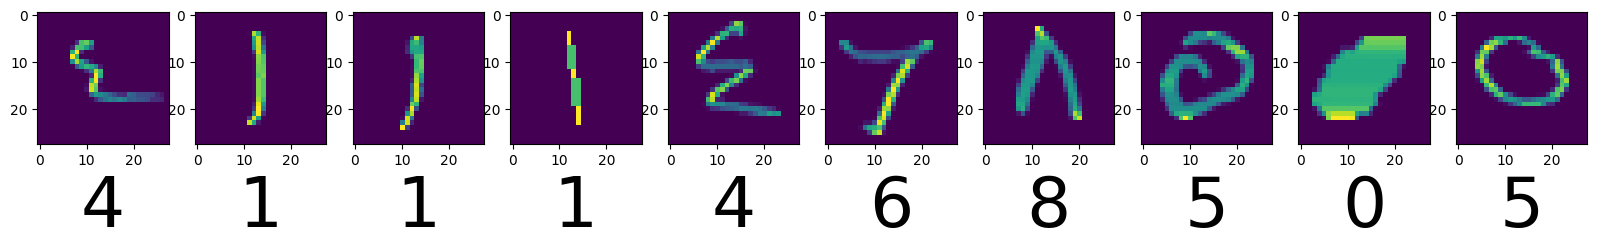

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(20,20))
for idx, x in enumerate(sample):
    ax[idx].imshow(x)
    ax[idx].set_xlabel(pred[idx].argmax(), fontsize=50)

## __The model does a moderate job in predicting.__

## __Finding the classification report for the model:__

In [ ]:
y_pred = model.predict(x_test)

313/313 [==============================] - 5s 15ms/step


In [ ]:
y_pred=np.argmax(y_pred, axis=1)

In [ ]:
y_testB=np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_testB, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       999
           1       0.99      0.99      0.99      1000
           2       0.99      0.99      0.99      1000
           3       1.00      0.99      0.99      1000
           4       1.00      1.00      1.00      1000
           5       0.99      0.98      0.99      1000
           6       1.00      0.99      0.99      1000
           7       1.00      0.99      1.00      1000
           8       1.00      1.00      1.00      1000
           9       0.99      0.99      0.99      1000

    accuracy                           0.99      9999
   macro avg       0.99      0.99      0.99      9999
weighted avg       0.99      0.99      0.99      9999

